# ML Taxi NB 2: Modelos de machine learning

#### En este notebook se realiza el análisis y predicción de datos para df_final generado en el NB1

In [73]:
#Importación de librerías y lectura de datos
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
df=pd.read_csv("data/df_final.csv")

In [74]:
df=df.sample(100000) # reducción de la muestra para pruebas y agilizar proceso

In [75]:
df.head(10)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,peak_hour,pickup_year,distance,pickup_hour_sin,pickup_hour_cos,pickup_minutes_sin,pickup_minutes_cos,pickup_month_sin,pickup_month_cos,pickup_day_sin,pickup_day_cos,day_of_week_sin,day_of_week_cos
139215,24.27,-73.874574,40.774060,-73.973956,40.756979,2,False,2009,8.582524,-7.308360e-01,0.682553,0.874763,0.484551,-0.866025,5.000000e-01,-0.201299,0.979530,-8.660254e-01,-0.5
499908,5.00,-74.011620,40.715393,-74.016769,40.708130,5,False,2015,0.916881,1.361666e-01,-0.990686,-0.971430,-0.237327,0.866025,5.000000e-01,0.299363,-0.954139,-8.660254e-01,0.5
778807,29.70,-73.874527,40.774013,-73.982988,40.762570,1,False,2011,9.222157,-2.449294e-16,1.000000,-0.211383,0.977403,0.866025,-5.000000e-01,-0.790776,-0.612106,8.660254e-01,-0.5
261575,11.50,-74.006637,40.733107,-74.014550,40.715385,1,False,2013,2.080363,-2.697968e-01,0.962917,-0.314077,0.949398,-0.866025,-5.000000e-01,0.937752,0.347305,8.660254e-01,0.5
647599,30.10,-73.975170,40.756958,-73.870890,40.774092,1,False,2011,8.986505,-3.984011e-01,-0.917211,0.638244,-0.769834,0.500000,-8.660254e-01,-0.651372,-0.758758,1.224647e-16,-1.0
863731,12.50,-73.958549,40.713073,-73.957071,40.745711,1,False,2013,3.631316,0.000000e+00,1.000000,0.106293,0.994335,1.000000,6.123234e-17,-0.968077,-0.250653,-8.660254e-01,-0.5
152814,7.30,-73.944688,40.779312,-73.958198,40.760342,1,False,2011,2.396625,-9.422609e-01,-0.334880,-0.991153,-0.132726,-0.866025,5.000000e-01,0.724793,0.688967,8.660254e-01,0.5
127156,5.30,-73.994864,40.740275,-74.006437,40.743865,1,True,2010,1.053551,-9.790841e-01,0.203456,0.211383,0.977403,0.500000,-8.660254e-01,-0.201299,0.979530,-2.449294e-16,1.0
19536,10.90,-74.005062,40.719210,-73.996577,40.760787,2,False,2011,4.678093,5.195840e-01,0.854419,-0.847734,-0.530421,-0.866025,5.000000e-01,0.394356,0.918958,-2.449294e-16,1.0
435634,3.70,-73.960412,40.783183,-73.962473,40.782037,5,False,2011,0.215291,-7.308360e-01,0.682553,0.991153,-0.132726,-0.866025,-5.000000e-01,-0.299363,-0.954139,8.660254e-01,-0.5


### Quick EDA

In [76]:
import plotly.express as px
import plotly.graph_objects as go

# Se genera la matriz de correlación usando Spearman
correlation_matrix = df.corr(method='spearman')

# Crea el gráfico de correlación utilizando plotly.graph_objects
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.columns,
    colorscale='RdBu',
    zmin=-1, zmax=1,
    colorbar=dict(title='Correlación', tickvals=[-1, 0, 1], ticktext=['-1', '0', '1']),
))

# Ajustar título y mostrar el gráfico
fig.update_layout(
    title='Matriz de Correlación Spearman',
    xaxis_title='Variables',
    yaxis_title='Variables',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    width=800, height=700
)

fig.show()

Se observan las relaciones entre las variables del dataframe y fare_amount, el target a predecir.Como se esperaba, las coordenadas de latitud y longitud en inicio y fin del viaje, están fuertemente correlacionadas. Por lo tanto, para incluirlas dentro de este análisis de ML, se aplicará un PCA (análisis de componentes principales).

Previo a esto, de realiza la división de datos en train y test, considerando el precio del viaje como la carcacterística a predecir.

In [77]:
#Se generan dataframes para características y targets
features = df.drop(columns = ["fare_amount"])
target = df["fare_amount"]

#Se ejecuta la división de datos para entrenar y probar el modelo, considerando X para features (variables independientes)
#  y Y para target (variable dependiente a predecir). Se asigna el 80% de los datos para entrenar el modelo, 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=42)

Análisis de PCA para Latitud y Longitud en inicio y fin de viaje

In [78]:
# PCA para reducir la dimensión
columns=['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude']

# Se importa la clase PCA desde sklearn.decomposition para realizar la reducción de dimensionalidad
from sklearn.decomposition import PCA

# Se crea una instancia de PCA y se configura para que mantenga el 70% de la varianza original
pca_train_latlong = PCA(n_components=0.7)

# Se ajusta el modelo PCA a los datos de entrenamiento. Esto calcula los componentes principales.
pca_train_latlong.fit(X_train[columns])

# Se transforman los datos de entrenamiento en el nuevo espacio de componentes principales
# Esto reduce la dimensionalidad de los datos manteniendo el 70% de la varianza.
latlongPCA_result_train = pca_train_latlong.transform(X_train[columns])

# Se obtiene el número de componentes generados en la transformación
num_components = latlongPCA_result_train.shape[1]

# Crear una lista de nombres de columnas para los nuevos componentes principales
# Los nombres se generan dinámicamente basados en el número de componentes generados
pca_column_names = [f'PCA_latlong_{i+1}' for i in range(num_components)]

# Se agregan las nuevas columnas al DataFrame X_train, las cuales contienen los componentes principales
X_train[pca_column_names] = latlongPCA_result_train

# Se realiza la transformación de los datos de prueba con el modelo PCA previamente ajustado
# Esto proyecta los datos de prueba en el mismo espacio de componentes principales
latlongPCA_result_test = pca_train_latlong.transform(X_test[columns])

# Se obtiene el número de componentes generados para los datos de prueba
num_components = latlongPCA_result_test.shape[1]

# Crear una lista de nombres de columnas para los componentes principales de los datos de prueba
# Los nombres se generan de la misma manera que para los datos de entrenamiento
pca_column_names = [f'PCA_latlong_{i+1}' for i in range(num_components)]

# Se agregan las nuevas columnas al DataFrame X_test, las cuales contienen los componentes principales para los datos de prueba
X_test[pca_column_names] = latlongPCA_result_test

import pickle
# Guardar el modelo entrenado en un archivo .pkl
with open('pca_train_latlong.pkl', 'wb') as file: 
    pickle.dump(pca_train_latlong, file) #

A continuación se realiza la selección de las variables a considerar para los modelos ML

In [69]:
#Selección para x train
X_train=X_train[['passenger_count', 'peak_hour', 'pickup_year',
       'distance', 'pickup_hour_sin', 'pickup_hour_cos', 'pickup_minutes_sin',
       'pickup_minutes_cos', 'pickup_month_sin', 'pickup_month_cos',
       'pickup_day_sin', 'pickup_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'PCA_latlong_1']]

#Selección para x test
X_test=X_test[['passenger_count', 'peak_hour', 'pickup_year',
       'distance', 'pickup_hour_sin', 'pickup_hour_cos', 'pickup_minutes_sin',
       'pickup_minutes_cos', 'pickup_month_sin', 'pickup_month_cos',
       'pickup_day_sin', 'pickup_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'PCA_latlong_1']]

Finalmente, se estandarizan los datos, previo al análisis de ML

In [79]:
# scaling the data 
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler= StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

import pickle
# Guardar el modelo entrenado en un archivo .pkl
with open('scaler.pkl', 'wb') as file: 
    pickle.dump(scaler, file) #

## Modelos Machine Learning
En este aparatado se prueban una serie de modelos predictivos de machine learning (regresores), para buscar aquel con la mejor aproximación a la predicción del precio por viaje. 

### Bagging and Pasting (Árbol de decisiones)

In [36]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import time

start_time = time.time()

# Initialize the Pasting model
pasting_reg = BaggingRegressor(
  estimator=DecisionTreeRegressor(max_depth=50),
  n_estimators=200,
  max_samples=2000,
  bootstrap=False  # This ensures that no bootstrap is done, which is characteristic of Pasting
)

# Train the model with normalized data
pasting_reg.fit(X_train_scaled, y_train)

# Evaluate the model's performance
pred = pasting_reg.predict(X_test_scaled)

end_time = time.time()
total_time = end_time - start_time
print(f"Tiempo total de ejecución: {total_time:.2f} segundos")

# Print evaluation metrics
print("MAE:", mean_absolute_error(y_test, pred))  # Mean Absolute Error

# RMSE using numpy
rmse = np.sqrt(mean_squared_error(y_test, pred))  # Calculate RMSE manually
print("RMSE:", rmse)

print("R2 score:", r2_score(y_test, pred))  # R-squared score


Tiempo total de ejecución: 7.33 segundos
MAE: 2.20804059
RMSE: 4.746700896038295
R2 score: 0.7644489921855667


### Random Forest

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

start_time = time.time()
# Initialize RandomForestRegressor
forest = RandomForestRegressor(n_estimators=100, max_depth=50)

# Train the model
forest.fit(X_train_scaled, y_train)

# Make predictions
pred = forest.predict(X_test_scaled)

end_time = time.time()
total_time = end_time - start_time
print(f"Tiempo total de ejecución: {total_time:.2f} segundos")

# Evaluate the model's performance
print("MAE:", mean_absolute_error(y_test, pred))  # Mean Absolute Error
print("RMSE:", mean_squared_error(y_test, pred))  # Root Mean Squared Error
print("R2 score:", r2_score(y_test, pred))  # R-squared score

Tiempo total de ejecución: 109.42 segundos
MAE: 2.1557949
RMSE: 21.651140449948
R2 score: 0.7736492117395173


### AdaBoost

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

start_time = time.time()

# Initialize AdaBoost Regressor with DecisionTree as base estimator
ada_reg = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=20),  # Changed 'base_estimator' to 'estimator'
    n_estimators=200
)

# Train the model with normalized data
ada_reg.fit(X_train_scaled, y_train)

# Make predictions
pred = ada_reg.predict(X_test_scaled)

end_time = time.time()
total_time = end_time - start_time
print(f"Tiempo total de ejecución: {total_time:.2f} segundos")

# Evaluate the model's performance
print("MAE:", mean_absolute_error(y_test, pred))  # Mean Absolute Error
print("RMSE:", mean_squared_error(y_test, pred))  # Root Mean Squared Error (RMSE)
print("R2 score:", r2_score(y_test, pred))  # R-squared score

Tiempo total de ejecución: 219.81 segundos
MAE: 2.062687864111605
RMSE: 20.017386334453054
R2 score: 0.7907292141865466


### Gradient Boosting

In [39]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

start_time = time.time()

# Initialize GradientBoostingRegressor
gb_reg = GradientBoostingRegressor(max_depth=20, n_estimators=100)

# Train the model with normalized data
gb_reg.fit(X_train_scaled, y_train)

# Make predictions
pred = gb_reg.predict(X_test_scaled)

end_time = time.time()
total_time = end_time - start_time
print(f"Tiempo total de ejecución: {total_time:.2f} segundos")

# Evaluate the model's performance
print("MAE:", mean_absolute_error(y_test, pred))  # Mean Absolute Error
print("RMSE:", mean_squared_error(y_test, pred))  # Root Mean Squared Error (RMSE)
print("R2 score:", r2_score(y_test, pred))  # R-squared score

Tiempo total de ejecución: 143.80 segundos
MAE: 2.486363562432596
RMSE: 34.10232956048797
R2 score: 0.6434788645254133


### XG BOOST

In [40]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

start_time = time.time()

# Create XGBoost regressor
xgb_reg = xgb.XGBRegressor(max_depth=20,
                           n_estimators=100,
                           learning_rate=0.1,  # default learning rate
                           booster='gbtree',   # default booster
                           objective='reg:squarederror')  # for regression tasks

# Train the model with normalized data
xgb_reg.fit(X_train_scaled, y_train)

# Make predictions
pred = xgb_reg.predict(X_test_scaled)

# Evaluate the model's performance
print("MAE:", mean_absolute_error(y_test, pred))  # Mean Absolute Error
print("RMSE:", mean_squared_error(y_test, pred))  # Root Mean Squared Error
print("R2 score:", r2_score(y_test, pred))  # R-squared score


end_time = time.time()
total_time = end_time - start_time
print(f"Tiempo total de ejecución: {total_time:.2f} segundos")


MAE: 2.32186192553997
RMSE: 27.297092651107516
R2 score: 0.7146238807567082
Tiempo total de ejecución: 22.39 segundos


### Selección del modelo final
Con base en las medidas calculadas, los resultados obtenidos con Random Forest representan la mayor puntuación en R2 Score (79%), y la MAE menor con 2.05 dolares. Por esta razón, se trabajará con este modelo la optimiación de hiperparámetros. 

### Random search para la optimización de hiperparámetros
En esta sección, se realiza la búsqueda de los parámatros que ofrecen los mejores resultados al aplicar el modelo Random Forest. Para esto, se define un diccionario con los hiperparámetros de Random Forest.

In [41]:
from sklearn.model_selection import RandomizedSearchCV
# Definir el espacio de hiperparámetros para RandomizedSearchCV
param_dist = {
    'n_estimators': [160,170,180],
    'max_features': [None],
    'max_depth': [22,23,24],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True],
    'criterion': ['squared_error']
}

rf=RandomForestRegressor() #Indico que quiero probar un modelo de random forest y lo guardo como rf

# Crear el objeto RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)
# Ajustar el modelo con los datos de entrenamiento
random_search.fit(X_train_scaled, y_train)

c:\Users\Gerardo\anaconda33\envs\en_taxi\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning:

The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.



Fitting 5 folds for each of 9 candidates, totalling 45 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'criterion': ['squared_error'],
                                        'max_depth': [22, 23, 24],
                                        'max_features': [None],
                                        'min_samples_leaf': [1],
                                        'min_samples_split': [2],
                                        'n_estimators': [160, 170, 180]},
                   random_state=42, verbose=2)

Se observa que los parámetros encotrados como ideales para obtener los mejores resultados de predicción con el modelo son: max_depth=23, max_features=None, n_estimators=170.
Esto se puede corroborar en las gráficas que se muestran a continuación, donde se identifica el punto con mayor score.

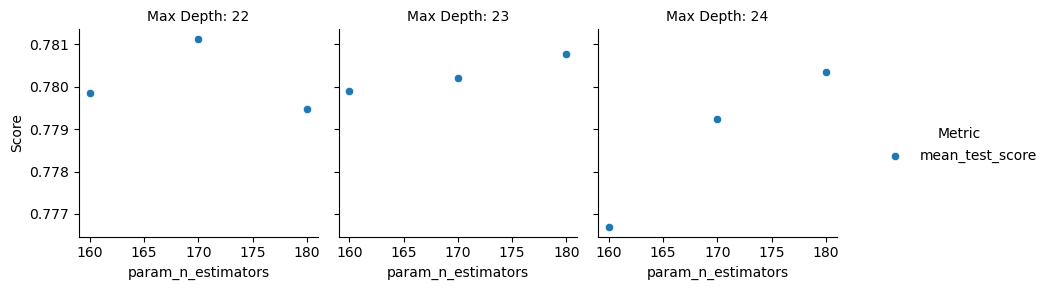

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'random_search' is your already fitted RandomizedSearchCV
results = pd.DataFrame(random_search.cv_results_)

# Select columns of interest
parameters = ['param_n_estimators', 'param_max_depth']
scores = 'mean_test_score'

# Prepare the data
results = results[parameters + [scores]]

# You can uncomment the following line to see the structure of your results
# print(results.head())

# Transform the data for better visualization
results_long = pd.melt(results, id_vars=parameters, value_vars=[scores], var_name='Metric', value_name='Score')

# Create a grid of plots for each combination of max_depth
g = sns.FacetGrid(results_long, col='param_max_depth', hue='Metric', margin_titles=True)
g.map(sns.scatterplot, 'param_n_estimators', 'Score')
g.add_legend()

# Adjust titles
g.set_titles(col_template="Max Depth: {col_name}")

# Show the plot
plt.show()



Con estos datos, se ejecuta nuevamente el modelo Random Forest para verificar los resultados. 

In [71]:
#Ejecución de random forest con los mejores hiperparametros.
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

start_time = time.time()
# Initialize RandomForestRegressor
forest = RandomForestRegressor(n_estimators=170, max_depth=22)

# Train the model
forest.fit(X_train_scaled, y_train)

# Make predictions
pred = forest.predict(X_test_scaled)

end_time = time.time()
total_time = end_time - start_time
print(f"Tiempo total de ejecución: {total_time:.2f} segundos")

# Evaluate the model's performance
print("MAE:", mean_absolute_error(y_test, pred))  # Mean Absolute Error
print("RMSE:", mean_squared_error(y_test, pred))  # Root Mean Squared Error
print("R2 score:", r2_score(y_test, pred))  # R-squared score

Tiempo total de ejecución: 100.97 segundos
MAE: 2.082552120796629
RMSE: 17.150846893172083
R2 score: 0.8150222407581703


In [80]:
import pickle
# Guardar el modelo entrenado en un archivo .pkl
with open('forest.pkl', 'wb') as file: 
    pickle.dump(forest, file) #

### Análisis de la importancia de cada variable en las predicciones del modelo
### Librería Shap
EN este apartado se emplea la librería shap para calcular los valores shap de cada variable, y así poder observar lo decisiva que es cada una de ellas en la variación de las tarifas.

In [13]:
import shap
# Aplicar SHAP para la explicación del modelo
shap.initjs()  # Inicializa la visualización interactiva de SHAP en Jupyter

# Usar KernelExplainer en lugar de TreeExplainer
explainer = shap.KernelExplainer(forest.predict, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)


Using 800 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [1:41:49<00:00, 30.55s/it]


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

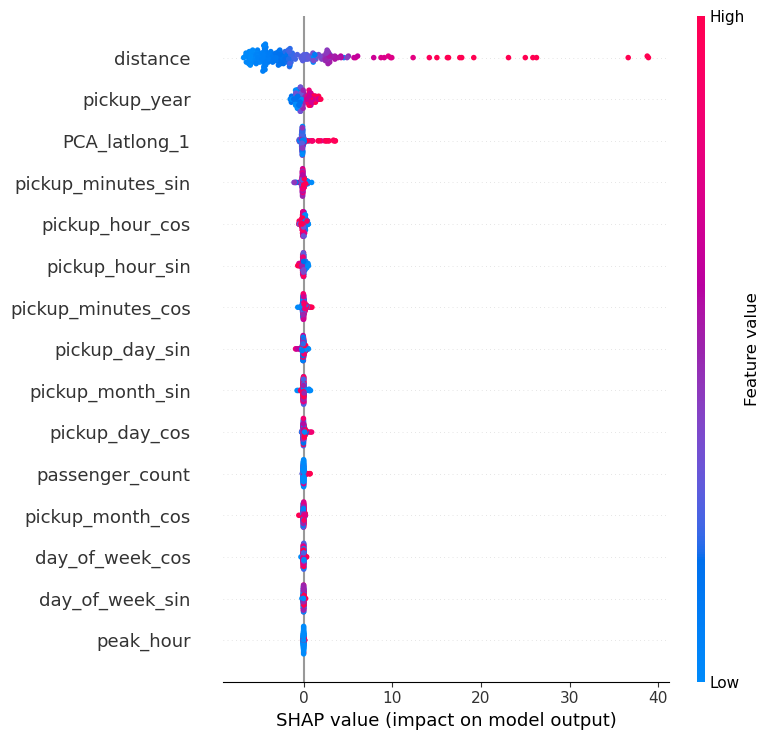

In [15]:
# Mostrar el resumen de SHAP
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)

### Summary plot
Se aprecia la variable distancia, calculada de manera lineal con las coordenadas de inicio y fin del viaje, como la más determinante al momento de generar una predicción con el modelo, seguida por la hora y el día de viaje. 

In [60]:
import shap
import plotly.express as px
import pandas as pd
import numpy as np

# Supongamos que ya tienes los valores shap calculados en 'shap_values'
# 'X_test_scaled' es el conjunto de datos de prueba escalado (en formato ndarray)
# Si X_test_scaled es un ndarray, conviértelo a un DataFrame

# Asegúrate de que X_test_scaled sea un DataFrame
if isinstance(X_test_scaled, pd.DataFrame):
    feature_names = X_test.columns
else:
    # Si es un ndarray, convierte a DataFrame y asigna los nombres de las columnas
    feature_names = [f'Feature {i}' for i in range(X_test_scaled.shape[1])]
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# Ahora, si shap_values es un ndarray, conviértelo en DataFrame
if isinstance(shap_values, np.ndarray):
    shap_df = pd.DataFrame(shap_values, columns=feature_names)
else:
    shap_df = pd.DataFrame(shap_values.values, columns=feature_names)

# Ordenar los valores de SHAP para cada característica de mayor a menor
shap_df_sorted = shap_df.abs().mean(axis=0).sort_values(ascending=False)

# Crear un gráfico de caja con Plotly
fig = px.box(
    shap_df[shap_df_sorted.index],  # Usamos el orden de características por la media absoluta
    points="all",  # Muestra todos los puntos (valores SHAP individuales)
    labels={col: col for col in shap_df_sorted.index},  # Etiquetas de las características
    title="Summary Plot de SHAP values"
)

# Mostrar el gráfico
fig.show()
